# Annotator Simulation

In [1]:
# notebook setup
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append('../../')

# import required packages
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('text', usetex=True)
#rc('font', family='serif')
rc('axes', edgecolor="black")

from annotlib.cluster_based import ClusterBasedAnnot

from scipy.spatial import ConvexHull

from src.utils.data_functions import investigate_data_set, load_data, preprocess_2d_data_set
from src.utils.plot_functions import plot_simulation

from sklearn.datasets import make_blobs, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/var/folders/c_/xdgt2ng54rqg9mndj12yw2jr0000gn/T/ipykernel_93958/1548074852.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Simulate Annotators on Real-world Data 

Run all cells below. As a result, `../../data` will contain .csv files of all data sets. Now, you are able to execute experiments.

In [2]:
# set random seeds
np.random.seed(42)
random_state = np.random.RandomState(40)

# obtain available data sets
data_set_names = pd.read_csv('/Users/kaizer/Documents/Active Learning/Code/mapal-master/data/data_set_ids.csv').name.values

# simulation for each data set
for d in data_set_names:
    print(d)
    # load data
    X, y_true, y = load_data(d)
    n_features = X.shape[1]
    n_classes = len(np.unique(y_true))
    X = X.values
    # standardize features
    X_trans = StandardScaler().fit_transform(X)


    print('n-features: {}, n-classes: {}'.format(n_features, n_classes))
    
    for s in ['x', 'o', 'y']:
        if s == 'x':
            # simulate annotators with instance-dependent performance values
            n_annotators = np.random.choice([4, 5, 6])
            y_cluster_k_means = KMeans(n_clusters=n_annotators, n_init=50, random_state=6).fit_predict(X_trans)
            
            U = np.random.uniform(0.8, 1.0, size=2*n_annotators).reshape(n_annotators, 2)
            E = np.array([np.arange(n_annotators), 
                          (np.arange(n_annotators)+2)%n_annotators]).reshape((n_annotators, 2))
            A = np.random.uniform(1/n_classes, 1/n_classes+0.2, n_annotators**2)
            A = A.reshape((n_annotators, n_annotators))
            A[np.arange(n_annotators), E[:, 0]] = U[:, 0]
            A[np.arange(n_annotators), E[:, 1]] = U[:, 1]
            C = np.empty((n_annotators, n_annotators, 2))
            C[:, :, 0] = A
            C[:, :, 1] = A
            annot = ClusterBasedAnnot(X=X_trans, y_true=y_true, y_cluster=y_cluster_k_means, n_annotators=n_annotators,
                                      cluster_labelling_acc=C, random_state=6)
        elif s == 'y':
            # simulate annotators with class-dependent performance values
            n_annotators = random_state.choice([4, 5, 6])
            A = random_state.uniform(1/n_classes, 1, size=n_annotators*n_classes).reshape((n_annotators, n_classes))
            C = np.empty((n_annotators, n_classes, 2))
            C[:, :, 0] = A
            C[:, :, 1] = A
            annot = ClusterBasedAnnot(X=X_trans, y_true=y_true, y_cluster=y_true, n_annotators=n_annotators,
                                      cluster_labelling_acc=C, random_state=6)
            
        elif s == 'o':
            # simulate annotators with uniform performance values
            n_annotators = np.random.choice([4, 5, 6])
            y_cluster_const = np.zeros(len(X), dtype=int)
            min_label_acc = 1. / n_classes
            label_acc_step = (0.9 - min_label_acc) / (n_annotators + 1)
            mean_label_acc = np.linspace(min_label_acc, 0.9 - 2 * label_acc_step, n_annotators)
            C = np.empty((n_annotators, 1, 2))
            for a in range(n_annotators):
                v = np.random.uniform(mean_label_acc[a], mean_label_acc[a] + 2 * label_acc_step)
                C[a, :, :] = v
            annot = ClusterBasedAnnot(X=X_trans, y_true=y_true, y_cluster=y_cluster_const, n_annotators=n_annotators,
                                      cluster_labelling_acc=C, random_state=6)
    
        #print('reached')
        #print(X.shape)
        #print(X.shape[1])
        #print(X[:,0])
        #data_set = dict()
        #for i in range(X.shape[1]):
            #data_set.update({'x_'+str(i):X[:,i]})
        #    print("i : ",i,X[:,i],sep="  ")
        #print('x_'+str(i))
        
        # store data set with simulated annotations
        data_set = {'x_{}'.format(i): X[:, i] for i in range(X.shape[1])}

        data_set['y'] = y_true
        for a in range(annot.n_annotators()): 
            data_set['y_'+str(a+1)] = annot.Y_[:, a]
        data_set = pd.DataFrame(data_set)
        data_set_name = '{}-simulated-{}'.format(d, s)
        filename = '../../data/{}.csv'.format(data_set_name)
        is_file_present = glob.glob(filename)
        if not is_file_present:
            data_set.to_csv(filename, index=False)
        print(s+': '+str(investigate_data_set(data_set_name=data_set_name)))

breast-cancer-wisconsin
n-features: 30, n-classes: 2
x: (30, array([357, 212]), array([0.71704745, 0.65553603, 0.72231986, 0.63093146, 0.68189807,
       0.71880492]))
o: (30, array([357, 212]), array([0.51669596, 0.67486819, 0.70650264, 0.7486819 , 0.89630931]))
y: (30, array([357, 212]), array([0.69420035, 0.75571178, 0.73110721, 0.71704745, 0.65026362,
       0.83304042]))
blood-transfusion
n-features: 4, n-classes: 2
x: (4, array([570, 178]), array([0.7540107 , 0.69518717, 0.61898396, 0.73128342, 0.69117647,
       0.68983957]))
o: (4, array([570, 178]), array([0.51069519, 0.68983957, 0.67112299, 0.71657754, 0.88235294]))
y: (4, array([570, 178]), array([0.76871658, 0.89705882, 0.65775401, 0.5802139 , 0.76336898,
       0.96524064]))
pima-indians-diabetes
n-features: 8, n-classes: 2
x: (8, array([500, 268]), array([0.67578125, 0.73046875, 0.67317708, 0.70572917, 0.66536458,
       0.75260417]))
o: (8, array([500, 268]), array([0.53515625, 0.63932292, 0.65104167, 0.79947917, 0.77604

ValueError: could not convert string to float: 'Male'

## Illustration of Simulation Techniques

Run the cells below to get an illustration of the different simulation techniques. 

In [ ]:
X, y_true = make_blobs(n_samples=300, n_features=2, centers=12, cluster_std=1, random_state=42)
X -= np.mean(X, keepdims=True, axis=0)
X /= np.std(X, keepdims=True, axis=0)
y_true %= 2
n_classes = len(np.unique(y_true))

### Example Data Set with Uniform Annotation Performance Values

[[[0.55992642 0.55992642]]

 [[0.73211429 0.73211429]]

 [[0.77711903 0.77711903]]

 [[0.83578536 0.83578536]]]


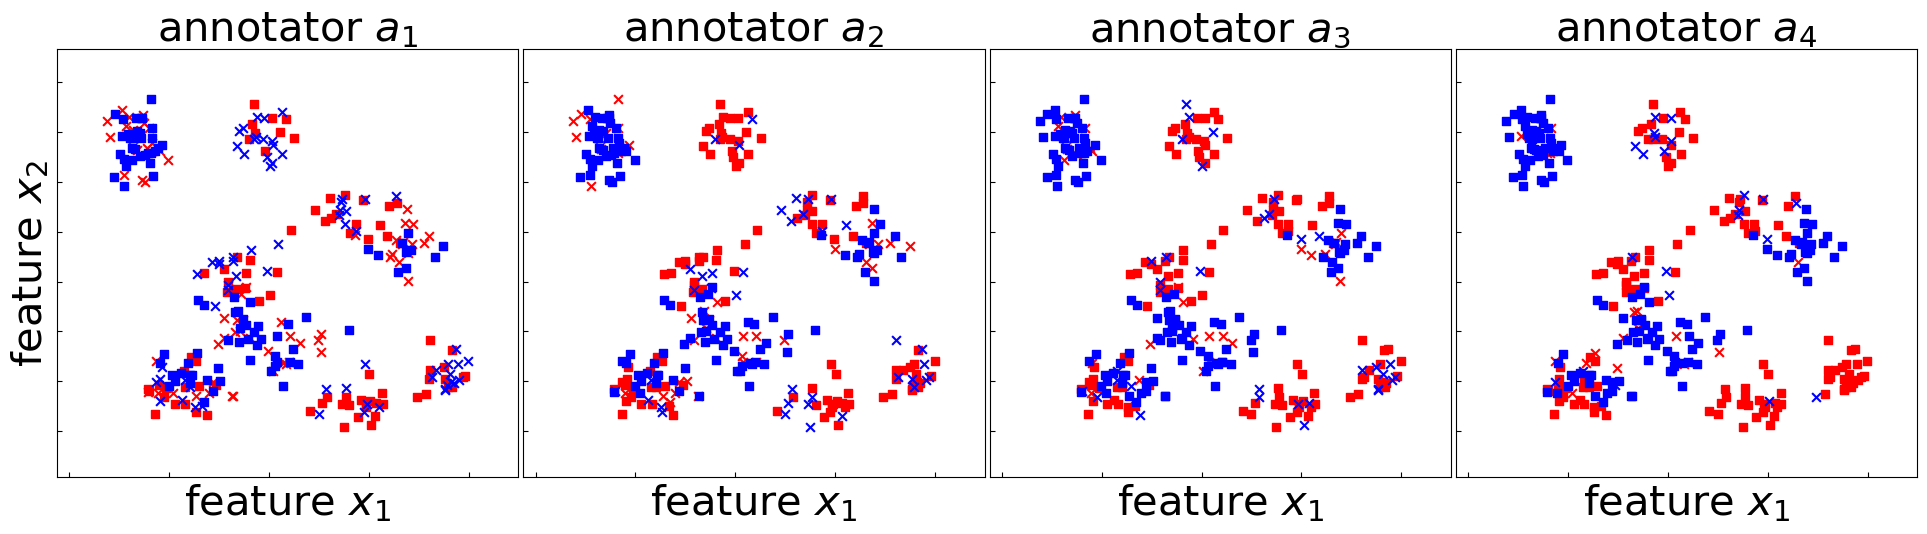

<Figure size 2400x1200 with 0 Axes>

In [ ]:
np.random.seed(42)
n_annotators = 4
y_cluster_const = np.zeros(len(X), dtype=int)
min_label_acc = 1. / n_classes
label_acc_step = (0.9 - min_label_acc) / (n_annotators + 1)
mean_label_acc = np.linspace(min_label_acc, 0.9 - 2 * label_acc_step, n_annotators)
C = np.empty((n_annotators, 1, 2))
for a in range(n_annotators):
    v = np.random.uniform(mean_label_acc[a], mean_label_acc[a] + 2 * label_acc_step)
    C[a, :, :] = v
print(C)
annot = ClusterBasedAnnot(X=X, y_true=y_true, y_cluster=y_cluster_const, n_annotators=n_annotators,
                          cluster_labelling_acc=C, random_state=0)

# save data set
data_set = {'x_{}'.format(i): X[:, i] for i in range(X.shape[1])}
data_set['y'] = y_true
for a in range(annot.n_annotators()): 
    data_set['y_'+str(a+1)] = annot.Y_[:, a]
data_set = pd.DataFrame(data_set)
data_set_name = 'example-data-set-o'
filename = '../../data/{}.csv'.format(data_set_name)
data_set.to_csv(filename, index=False)
fig = plot_simulation(X=X, y_true=y_true, y=annot.Y_, figsize=(24, 12), fontsize=30,
                      filename='../../plots/simulated-o', filetype='svg')

### Example Data Set with Class-dependent Annotation Performance Values

[[0.68727006 0.97535715]
 [0.86599697 0.79932924]
 [0.57800932 0.57799726]
 [0.52904181 0.93308807]]


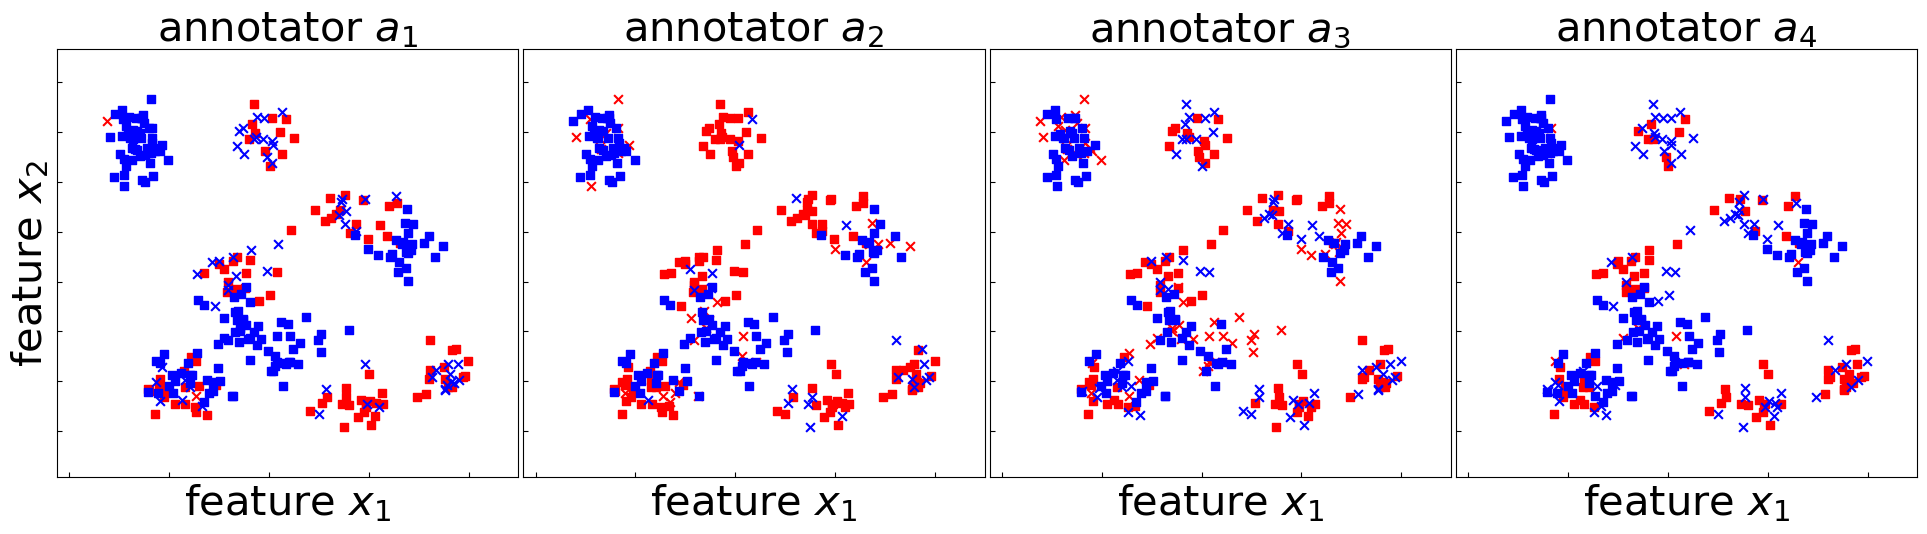

<Figure size 2400x1200 with 0 Axes>

In [ ]:
np.random.seed(42)
n_annotators = 4
y_cluster_const = np.zeros(len(X), dtype=int)
A = np.random.uniform(1/n_classes, 1, size=n_annotators*n_classes).reshape((n_annotators, n_classes))
C = np.empty((n_annotators, n_classes, 2))
C[:, :, 0] = A
C[:, :, 1] = A
annot = ClusterBasedAnnot(X=X, y_true=y_true, y_cluster=y_true, n_annotators=n_annotators,
                          cluster_labelling_acc=C, random_state=0)
print(C[:, :, 0])

# save data set
data_set = {'x_{}'.format(i): X[:, i] for i in range(X.shape[1])}
data_set['y'] = y_true
for a in range(annot.n_annotators()): 
    data_set['y_'+str(a+1)] = annot.Y_[:, a]
data_set = pd.DataFrame(data_set)
data_set_name = 'example-data-set-y'
filename = '../../data/{}.csv'.format(data_set_name)
data_set.to_csv(filename, index=False)
fig = plot_simulation(X=X, y_true=y_true, y=annot.Y_, figsize=(24, 12), fontsize=30,
                      filename='../../plots/simulated-y', filetype='svg')

### Example Data Set with Instance-dependent Annotion Performance Values

(array([0, 1, 2, 3], dtype=int32), array([ 51, 120,  54,  75]))
[[0.87490802 0.99014286 0.5041169  0.69398197]
 [0.66648853 0.54246782 0.94639879 0.9197317 ]
 [0.56084845 0.60495129 0.83120373 0.8311989 ]
 [0.81161672 0.97323523 0.55842893 0.57327237]]
(array([0, 1, 2, 3], dtype=int32), array([ 51, 120,  54,  75]))


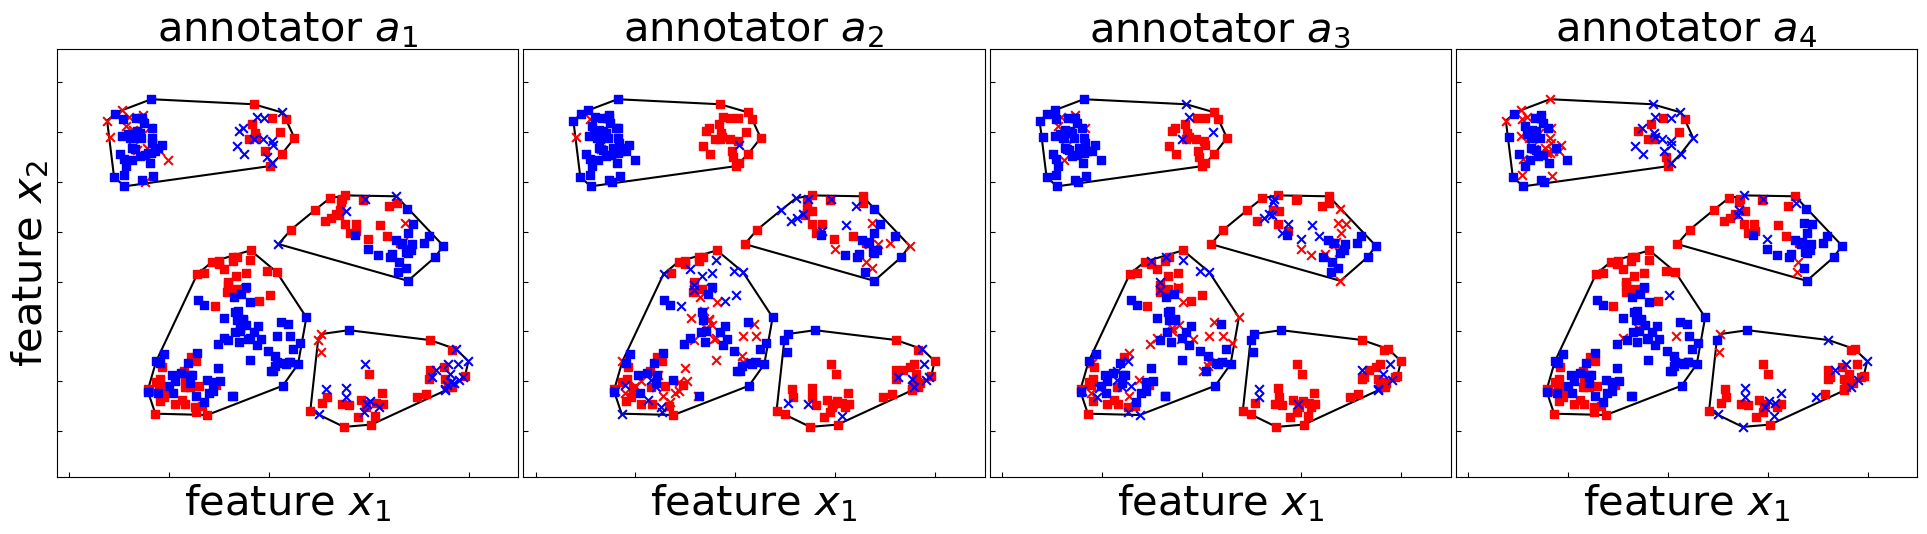

<Figure size 2400x1200 with 0 Axes>

In [ ]:
np.random.seed(42)
n_annotators = 4
y_cluster_k_means = KMeans(n_clusters=n_annotators, n_init=50, random_state=0).fit_predict(X)
print(np.unique(y_cluster_k_means, return_counts=True))

U = np.random.uniform(0.8, 1.0, size=2*n_annotators).reshape(n_annotators, 2)
E = np.array([np.arange(n_annotators), 
              (np.arange(n_annotators)+2)%n_annotators]).reshape((n_annotators, 2))
A = np.random.uniform(1/n_classes, 1/n_classes+0.2, n_annotators**2)
A = A.reshape((n_annotators, n_annotators))
A[np.arange(n_annotators), E[:, 0]] = U[:, 0]
A[np.arange(n_annotators), E[:, 1]] = U[:, 1]
C = np.empty((n_annotators, n_annotators, 2))
C[:, :, 0] = A
C[:, :, 1] = A
print(C[:, :, 0])
print(np.unique(y_cluster_k_means, return_counts=True))

# simulate annotators
annot = ClusterBasedAnnot(X=X, y_true=y_true, y_cluster=y_cluster_k_means, n_annotators=n_annotators, 
                          cluster_labelling_acc=C, random_state=0)

# save data set
data_set = {'x_{}'.format(i): X[:, i] for i in range(X.shape[1])}
data_set['y'] = y_true
for a in range(annot.n_annotators()): 
    data_set['y_'+str(a+1)] = annot.Y_[:, a]
data_set = pd.DataFrame(data_set)
data_set_name = 'example-data-set-x'
filename = '../../data/{}.csv'.format(data_set_name)
data_set.to_csv(filename, index=False)
fig = plot_simulation(X=X, y_true=y_true, y=annot.Y_, figsize=(24, 12), fontsize=30,
                      filename='../../plots/simulated-x', filetype='svg', y_cluster=y_cluster_k_means)

(array([0, 1, 2, 3], dtype=int32), array([407, 252, 170, 171]))
[[0.87490802 0.99014286 0.5041169  0.69398197]
 [0.66648853 0.54246782 0.94639879 0.9197317 ]
 [0.56084845 0.60495129 0.83120373 0.8311989 ]
 [0.81161672 0.97323523 0.55842893 0.57327237]]
(array([0, 1, 2, 3], dtype=int32), array([407, 252, 170, 171]))


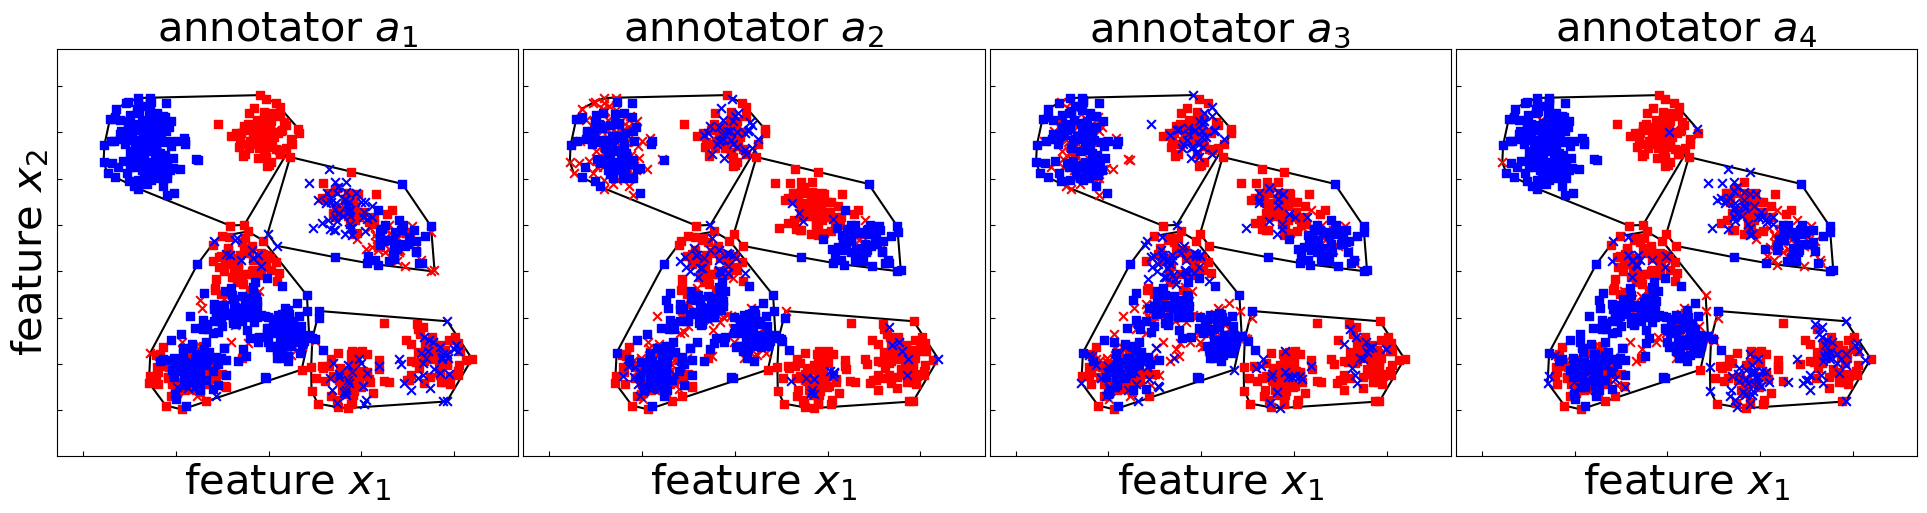

<Figure size 2400x1200 with 0 Axes>

In [ ]:
X, y_true = make_blobs(n_samples=1000, n_features=2, centers=12, cluster_std=1, random_state=42)
X -= np.mean(X, keepdims=True, axis=0)
X /= np.std(X, keepdims=True, axis=0)
y_true %= 2
n_classes = len(np.unique(y_true))

np.random.seed(42)
n_annotators = 4
y_cluster_k_means = KMeans(n_clusters=n_annotators, n_init=50, random_state=0).fit_predict(X)
print(np.unique(y_cluster_k_means, return_counts=True))

U = np.random.uniform(0.8, 1.0, size=2*n_annotators).reshape(n_annotators, 2)
E = np.array([np.arange(n_annotators), 
              (np.arange(n_annotators)+2)%n_annotators]).reshape((n_annotators, 2))
A = np.random.uniform(1/n_classes, 1/n_classes+0.2, n_annotators**2)
A = A.reshape((n_annotators, n_annotators))
A[np.arange(n_annotators), E[:, 0]] = U[:, 0]
A[np.arange(n_annotators), E[:, 1]] = U[:, 1]
C = np.empty((n_annotators, n_annotators, 2))
C[:, :, 0] = A
C[:, :, 1] = A
print(C[:, :, 0])
print(np.unique(y_cluster_k_means, return_counts=True))

# simulate annotators
annot = ClusterBasedAnnot(X=X, y_true=y_true, y_cluster=y_cluster_k_means, n_annotators=n_annotators, 
                          cluster_labelling_acc=C, random_state=0)

# save data set
data_set = {'x_{}'.format(i): X[:, i] for i in range(X.shape[1])}
data_set['y'] = y_true
for a in range(annot.n_annotators()): 
    data_set['y_'+str(a+1)] = annot.Y_[:, a]
data_set = pd.DataFrame(data_set)
data_set_name = 'large-example-data-set-x'
filename = '../../data/{}.csv'.format(data_set_name)
data_set.to_csv(filename, index=False)
fig = plot_simulation(X=X, y_true=y_true, y=annot.Y_, figsize=(24, 12), fontsize=30,
                      filename='../../plots/simulated-x-large', filetype='svg', y_cluster=y_cluster_k_means)